🖼️ Individual plots will be saved to: 5_Results_Predicted/TS_ESMC_4.0A/individual_sample_plots
🔍 GAT Grad-CAM Analyzer Initialized | Device: cuda
📁 Results will be saved to: 5_Results_Predicted/TS_ESMC_4.0A
🚀 Starting Full Analysis...
✅ Loaded 5 models.
✅ Loaded 9297 test samples.

💾 All prediction results saved to: 5_Results_Predicted/TS_ESMC_4.0A/all_predictions.csv
🎯 Found 120 samples for Grad-CAM analysis. Starting...

==================== Analyzing dbAMP_32240 ====================

🚀 Running Ensemble Grad-CAM for target class 1...
  ✅ Ensemble Grad-CAM computed.

🧪 Validating Grad-CAM results...
  Original Graph: 33 nodes | Original Prob: 0.9873

  --- Masking Most Important 20% ---
    - Zeroing Features -> New Prob: 0.7082, Drop: +0.2791

  --- Masking Least Important 20% ---
    - Zeroing Features -> New Prob: 0.9232, Drop: +0.0641
🖼️  Individual visualization saved to 5_Results_Predicted/TS_ESMC_4.0A/individual_sample_plots/sample_dbAMP_32240_grad_cam.png

====================

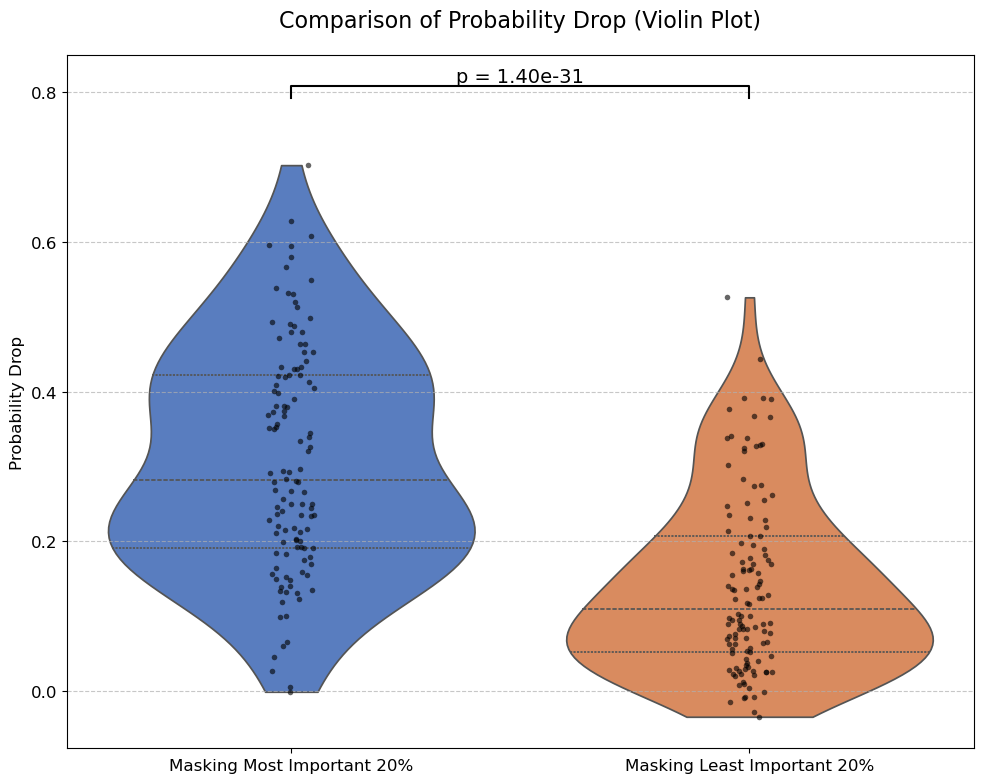

📈 Violin plot saved to: 5_Results_Predicted/TS_ESMC_4.0A/validation_violinplot.png

🎉 Full analysis finished successfully!


In [3]:
# ==================== 1. IMPORTS & CONFIG ====================
import torch
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.loader import DataLoader
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.stats import ttest_rel


# 假设本地模块已在路径中
from Feature_extraction.utils import load_dataset
from Model_training_and_testing.GAT import create_model

# --- Matplotlib 和警告配置 ---
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 600
warnings.filterwarnings('ignore')

class AnalysisConfig:
    """集中管理所有分析参数"""
    # --- 模型和数据路径 ---
    MODEL_DIR = Path('4_Results_TR_RS/GAT_Comparison_4.0A/3Layer_GAT/models')
    TEST_DATA_PATH = '3_Graph_Data/TS/TS_ESMC_4.0A.pkl'
    
    # --- 分析参数 ---
    BATCH_SIZE = 64
    SAVE_INDIVIDUAL_PLOTS = True # ✅ 开关: True则保存每个样本的可视化图, False则不保存

    # --- 可视化参数 ---
    NODE_SIZE = 1000
    FONT_SIZE = 26
    POSITION_FONT_SIZE = 20
    AVP_COLORMAP = 'Greens'
    NON_AVP_COLORMAP = 'Reds'
    TOP_K_AMINO_ACIDS = 5

# ==================== 2. GAT GRAD-CAM 分析器 ====================
class GATGradCAMAnalyzer:
    """
    专注于GAT Grad-CAM方法的模型可解释性分析器
    """
    def __init__(self, config: AnalysisConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.output_dir = Path("5_Results_Predicted") / Path(config.TEST_DATA_PATH).stem
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        if self.config.SAVE_INDIVIDUAL_PLOTS:
            self.individual_plots_dir = self.output_dir / "individual_sample_plots"
            self.individual_plots_dir.mkdir(parents=True, exist_ok=True)
            print(f"🖼️ Individual plots will be saved to: {self.individual_plots_dir}")

        self.model_activations = None
        self.model_gradients = None
        self.cam_analysis_results = []
        print(f"🔍 GAT Grad-CAM Analyzer Initialized | Device: {self.device}")
        print(f"📁 Results will be saved to: {self.output_dir}")

    # ---------- 2.1 数据和模型加载 ----------
    def load_models(self):
        model_paths = sorted(self.config.MODEL_DIR.glob("best_model_fold_*.pth"))
        if not model_paths: raise FileNotFoundError(f"No models found in {self.config.MODEL_DIR}")
        models = []
        for path in model_paths:
            checkpoint = torch.load(path, map_location=self.device, weights_only=False)
            model = create_model(**checkpoint['model_params']).to(self.device)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            models.append(model)
        print(f"✅ Loaded {len(models)} models.")
        return models

    def load_data(self):
        data = load_dataset(self.config.TEST_DATA_PATH)
        print(f"✅ Loaded {len(data)} test samples.")
        return data

    # ---------- 2.2 预测与样本选择 ----------
    def get_predictions(self, models, data):
        loader = DataLoader(data, batch_size=self.config.BATCH_SIZE, shuffle=False)
        all_probs = []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(self.device)
                batch_probs = [torch.softmax(model(batch.x, batch.edge_index, batch.batch)[0], dim=1)[:, 1] for model in models]
                all_probs.extend(torch.stack(batch_probs).mean(dim=0).cpu().numpy())
        return np.array(all_probs)

    def select_and_filter_samples(self, data, probs, predictions):
        qualified_indices = [
            idx for idx, (graph, prob, pred) in enumerate(zip(data, probs, predictions))
            if 0.9 <= prob < 0.99 and graph.num_nodes > 15 and graph.y.item() == pred
        ]
        if not qualified_indices:
            print("⚠️ No samples found that meet all criteria for Grad-CAM analysis.")
        else:
            print(f"🎯 Found {len(qualified_indices)} samples for Grad-CAM analysis. Starting...")
        return qualified_indices

    # ---------- 2.3 GAT Grad-CAM 计算与验证 ----------
    def _forward_hook(self, module, input, output): self.model_activations = output[0] if isinstance(output, tuple) else output
    def _backward_hook(self, module, grad_input, grad_output): self.model_gradients = grad_output[0]

    def compute_grad_cam(self, model, graph, target_class):
        model.eval(); model.zero_grad()
        last_gat_layer = next((m for m in model.modules() if isinstance(m, GATConv)), None)
        if last_gat_layer is None: raise ValueError("Model does not contain a GATConv layer.")
        
        f_handle = last_gat_layer.register_forward_hook(self._forward_hook)
        b_handle = last_gat_layer.register_full_backward_hook(self._backward_hook)
        try:
            output, _ = model(graph.x, graph.edge_index, graph.batch)
            output[0, target_class].backward()
            if self.model_gradients is None or self.model_activations is None: raise RuntimeError("Failed to capture gradients or activations.")
            weights = torch.mean(self.model_gradients, dim=0)
            cam = F.relu(torch.sum(self.model_activations * weights, dim=1))
            scores = cam.detach().cpu().numpy()
            return scores / scores.max() if scores.max() > 0 else scores
        finally:
            f_handle.remove(); b_handle.remove()
            self.model_activations = self.model_gradients = None
            model.zero_grad()

    def validate_grad_cam(self, models, graph, importance_scores, original_prob, target_class):
        results = {}
        print("\n🧪 Validating Grad-CAM results...")
        print(f"  Original Graph: {graph.num_nodes} nodes | Original Prob: {original_prob:.4f}")
        results['Original_Prob'] = original_prob

        for most_important in [True, False]:
            prefix = "Most_Important" if most_important else "Least_Important"
            print(f"\n  --- Masking {prefix.replace('_', ' ')} 20% ---")
            
            num_nodes_to_mask = max(1, int(len(importance_scores) * 0.20))
            sorted_indices = np.argsort(importance_scores)
            indices_to_mask = sorted_indices[-num_nodes_to_mask:] if most_important else sorted_indices[:num_nodes_to_mask]
            masked_scores = importance_scores[indices_to_mask]
            
            graph_zeroed = graph.clone()
            graph_zeroed.x[indices_to_mask] = 0.0
            prob_zeroed = self._get_ensemble_prediction_prob(models, graph_zeroed, target_class)
            drop_zeroed = original_prob - prob_zeroed
            
            print(f"    - Zeroing Features -> New Prob: {prob_zeroed:.4f}, Drop: {drop_zeroed:+.4f}")
            
            results[f'{prefix}_Nodes_20p'] = ' '.join(map(str, indices_to_mask + 1))
            results[f'{prefix}_Scores_20p'] = ' '.join(map(lambda x: f"{x:.4f}", masked_scores))
            results[f'Prob_After_Masking_{prefix}_20p'] = prob_zeroed
            results[f'Drop_{prefix}_20p'] = drop_zeroed
        return results

    def _get_ensemble_prediction_prob(self, models, graph, target_class):
        if graph.num_nodes == 0: return 0.5
        with torch.no_grad():
            probs = [torch.softmax(m(graph.x, graph.edge_index, graph.batch)[0], dim=1)[0, target_class].item() for m in models]
        return np.mean(probs)

    def run_ensemble_grad_cam(self, models, graph, target_class):
        print(f"\n🚀 Running Ensemble Grad-CAM for target class {target_class}...")
        all_scores = [self.compute_grad_cam(m, graph, target_class) for m in models]
        final_importance = np.mean(all_scores, axis=0)
        if final_importance.max() > 0: final_importance /= final_importance.max()
        
        print("  ✅ Ensemble Grad-CAM computed.")
        original_prob = self._get_ensemble_prediction_prob(models, graph, target_class)
        validation_results = self.validate_grad_cam(models, graph, final_importance, original_prob, target_class)
        return final_importance, validation_results

    # ---------- 2.4 可视化与保存 ----------
    def save_prediction_results(self, data, probabilities, predictions):
        """保存所有样本的预测结果"""
        results = []
        for i, graph in enumerate(data):
            true_label = "AVP" if graph.y.item() == 1 else "non-AVP"
            pred_label = "AVP" if predictions[i] == 1 else "non-AVP"
            results.append({
                'Sequence_ID': getattr(graph, 'seq_id', f'sample_{i}'),
                'sequence': getattr(graph, 'sequence', ''),
                'true_label': true_label,
                'predicted_label': pred_label,
                'probability': probabilities[i],
                'correct': true_label == pred_label,
                'num_nodes': graph.num_nodes
            })
        
        df = pd.DataFrame(results)
        save_path = self.output_dir / "all_predictions.csv"
        df.to_csv(save_path, index=False, float_format='%.4f')
        print(f"\n💾 All prediction results saved to: {save_path}")

    def save_grad_cam_results(self):
        """保存Grad-CAM分析结果并打印异常肽"""
        if not self.cam_analysis_results: 
            print("\nNo Grad-CAM results to save.")
            return
            
        df = pd.DataFrame(self.cam_analysis_results)
        
        # 找出异常肽
        print("\n--------------------------------------------------")
        print("Checking for anomalous peptides (Drop_Least > Drop_Most)...")
        anomalous_peptides = df[df['Drop_Least_Important_20p'] > df['Drop_Most_Important_20p']]
        
        if not anomalous_peptides.empty:
            print("⚠️ Found anomalous peptides where masking LEAST important nodes had a larger drop:")
            for pid in anomalous_peptides['ID']:
                print(f"  - {pid}")
        else:
            print("✅ No anomalous peptides found.")
        print("--------------------------------------------------")

        # 定义最终输出的列顺序
        output_columns = [
            'ID', 'Original_Prob',
            'Most_Important_Nodes_20p', 'Most_Important_Scores_20p',
            'Prob_After_Masking_Most_Important_20p', 'Drop_Most_Important_20p',
            'Least_Important_Nodes_20p', 'Least_Important_Scores_20p',
            'Prob_After_Masking_Least_Important_20p', 'Drop_Least_Important_20p'
        ]
        df = df[output_columns]

        save_path = self.output_dir / "grad_cam_analysis_results.csv"
        df.to_csv(save_path, index=False, float_format='%.4f')
        print(f"\n💾 Grad-CAM analysis results saved to: {save_path}")

    def create_and_save_validation_plots(self):
        """创建并保存验证结果的对比图，并将四分位数保存到CSV。"""
        if not self.cam_analysis_results: print("\nNo data for validation plots."); return
        df = pd.DataFrame(self.cam_analysis_results)
        
        drop_most = df['Drop_Most_Important_20p']
        drop_least = df['Drop_Least_Important_20p']

        positive_diff_ratio = (drop_most > drop_least).mean()
        print("\n📊 --- Validation Statistics ---")
        print(f"  - Positive Difference Ratio: {positive_diff_ratio:.2%}")
        
        if len(drop_most) > 1:
            t_stat, p_value = ttest_rel(drop_most, drop_least)
            print(f"  - Paired T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4g}")
            p_text = f'p = {p_value:.2e}' if p_value < 0.01 else f'p = {p_value:.3f}'
        else:
            p_text = "p-value n/a (n≤1)"; p_value = 1.0

        # --- 1. 保存四分位数到CSV文件 ---
        most_quartiles = np.percentile(drop_most, [25, 50, 75])
        least_quartiles = np.percentile(drop_least, [25, 50, 75])
        
        quartile_data = {
            'Statistic': ['25th_Percentile', '50th_Percentile (Median)', '75th_Percentile'],
            'Masking_Most_Important_20%': most_quartiles,
            'Masking_Least_Important_20%': least_quartiles
        }
        quartile_df = pd.DataFrame(quartile_data)
        quartile_save_path = self.output_dir / "validation_plot_quartiles.csv"
        quartile_df.to_csv(quartile_save_path, index=False, float_format='%.4f')
        print(f"💾 Quartile statistics for the plot saved to: {quartile_save_path}")

        # --- 2. 绘制图表 ---
        plt.figure(figsize=(10, 8))
        plot_df = pd.DataFrame({
            'Probability Drop': np.concatenate([drop_most, drop_least]),
            'Group': ['Masking Most Important 20%'] * len(drop_most) + ['Masking Least Important 20%'] * len(drop_least)
        })
        
        # 绘制小提琴图和散点图，不添加图例
        ax = sns.violinplot(x='Group', y='Probability Drop', data=plot_df, palette='muted', inner='quartile', cut=0)
        sns.stripplot(x='Group', y='Probability Drop', data=plot_df, color='black', jitter=0.05, size=4, alpha=0.6)
        
        # 恢复原始的坐标轴标签和标题
        plt.title('Comparison of Probability Drop (Violin Plot)', fontsize=16, pad=20)
        plt.ylabel('Probability Drop', fontsize=12)
        plt.xlabel('') # X轴标签留空
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # 添加p值注释
        if p_value < 0.05 and len(drop_most) > 1:
            y_max = plot_df['Probability Drop'].max()
            y_level = y_max * 1.15
            plt.plot([0, 0, 1, 1], [y_level*0.98, y_level, y_level, y_level*0.98], lw=1.5, c='black')
            plt.text(0.5, y_level, p_text, ha='center', va='bottom', fontsize=14)

        plt.tight_layout()
        save_path = self.output_dir / "validation_violinplot.png" # 恢复原始文件名
        plt.savefig(save_path)
        plt.show()
        print(f"📈 Violin plot saved to: {save_path}")
        
    def get_top_k_amino_acids(self, importance, sequence, k=5):
        """获取Top K重要氨基酸的信息"""
        # 对重要性分数进行排序，获取分数最高的k个索引
        top_k_indices = np.argsort(importance)[-k:][::-1]
        # 创建包含氨基酸、位置（1-based）和分数的元组列表
        top_k_info = [
            (sequence[i], i + 1, importance[i]) for i in top_k_indices
        ]
        return top_k_info
    
    def visualize_sample(self, result):
        """为单个样本生成并保存可视化图"""
        seq_len = len(result['sequence'])
        # 调整图形尺寸以适应新布局
        fig_width = max(18, seq_len * 0.7)
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, 6))
        
        # 准备标题中需要用到的文本
        top_k_info = self.get_top_k_amino_acids(
            result['importance'], result['sequence'], self.config.TOP_K_AMINO_ACIDS)
        
        true_label = "AVP" if result['graph'].y.item() == 1 else "non-AVP"
        pred_label = "AVP" if result['pred'] == 1 else "non-AVP"
        
        top_k_text = ", ".join([f"{aa}({pos}): {score:.3f}" for aa, pos, score in top_k_info])
        
        # 构建新的多行标题
        title_line1 = f"{result['sequence']} (ID: {result['seq_id']})"
        title_line2 = f"True: {true_label} | Predicted: {pred_label} (Prob: {result['prob']:.3f})"
        # 仅在预测正确时添加 "Prediction Correct"
        title_line3 = "Prediction Correct" if true_label == pred_label else ""
        title_line4 = f"Top Normalized Node Importance: {top_k_text}"
        
        # 合并标题行，如果 line3 为空，则会被 filter 掉
        full_title = "\n".join(filter(None, [title_line1, title_line2, title_line3, title_line4]))
        
        ax.set_title(full_title, fontsize=24, pad=40, loc='center')
        
        self._plot_linear_sequence(ax, result)
        
        # 绘制颜色条
        cmap = plt.cm.get_cmap(self.config.AVP_COLORMAP if result['pred'] == 1 else self.config.NON_AVP_COLORMAP)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="1.5%", pad=0.2)
        
        # 调整颜色条参数并修改标签
        cbar = plt.colorbar(sm, cax=cax, shrink=0.8)
        cbar.set_label('Node Importance', fontsize=12, rotation=270, labelpad=20)
        
        ax.set_ylim(-1, 1) # 调整Y轴范围以使布局更紧凑
        ax.axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.9]) # 调整布局为标题留出空间
        
        # 1. 修改保存路径到 individual_sample_plots 目录
        save_path = self.individual_plots_dir / f"sample_{result['seq_id']}_grad_cam.png"
        plt.savefig(save_path, bbox_inches='tight')
        
        # 2. 移除 plt.show() 并关闭图形，防止其显示
        plt.close(fig) 
        
        print(f"🖼️  Individual visualization saved to {save_path}")

    def _plot_linear_sequence(self, ax, result):
        seq, importance = result['sequence'], result['importance']
        G = nx.path_graph(len(seq))
        pos = {i: (i, 0) for i in range(len(seq))}
        cmap = plt.get_cmap(self.config.AVP_COLORMAP if result['pred'] == 1 else self.config.NON_AVP_COLORMAP)
        
        nx.draw_networkx_nodes(G, pos, node_color=importance, cmap=cmap, vmin=0, vmax=1, node_size=self.config.NODE_SIZE, edgecolors='black', ax=ax)
        nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, ax=ax)
        nx.draw_networkx_labels(G, pos, labels=dict(enumerate(seq)), font_size=self.config.FONT_SIZE, font_color='white', font_weight='bold', ax=ax)
        nx.draw_networkx_labels(G, {i: (i, -0.35) for i in range(len(seq))}, labels={i: str(i+1) for i in range(len(seq))}, font_size=self.config.POSITION_FONT_SIZE, font_color='black', ax=ax)

    # ---------- 2.5 主执行流程 ----------
    def run(self):
        """执行完整的分析流程"""
        print("🚀 Starting Full Analysis...")
        models = self.load_models()
        data = self.load_data()
        
        # 步骤1: 对所有样本进行预测并保存结果
        probabilities = self.get_predictions(models, data)
        predictions = (probabilities > 0.5).astype(int)
        self.save_prediction_results(data, probabilities, predictions)
        
        # 步骤2: 筛选样本进行Grad-CAM分析
        selected_indices = self.select_and_filter_samples(data, probabilities, predictions) 
        if not selected_indices: 
            print("\nAnalysis finished as no samples met the criteria for Grad-CAM.")
            return

        # 步骤3: 对筛选出的样本执行Grad-CAM
        for idx in selected_indices:
            graph = data[idx] 
            seq_id = getattr(graph, 'seq_id', f'sample_{idx}')
            print(f"\n{'='*20} Analyzing {seq_id} {'='*20}")
            
            graph_gpu = graph.clone().to(self.device)
            graph_gpu.batch = torch.zeros(graph_gpu.num_nodes, dtype=torch.long, device=self.device)
            
            importance, validation_results = self.run_ensemble_grad_cam(models, graph_gpu, predictions[idx])
            
            if validation_results:
                validation_results['ID'] = seq_id
                self.cam_analysis_results.append(validation_results)
            
            if self.config.SAVE_INDIVIDUAL_PLOTS and importance is not None:
                self.visualize_sample({
                    'seq_id': seq_id, 'sequence': getattr(graph, 'sequence', ''),
                    'prob': probabilities[idx], 'pred': predictions[idx],
                    'importance': importance, 'graph': graph
                })
        
        # 步骤4: 保存Grad-CAM结果并生成统计图
        self.save_grad_cam_results()
        self.create_and_save_validation_plots()

# ==================== 3. MAIN EXECUTION ====================
if __name__ == "__main__":
    try:
        config = AnalysisConfig()
        # --- ✅ 在这里控制是否保存单样本图片 ---
        config.SAVE_INDIVIDUAL_PLOTS = True 
        
        analyzer = GATGradCAMAnalyzer(config)
        analyzer.run()
        
        print("\n🎉 Full analysis finished successfully!")

    except Exception as e:
        print(f"\n❌ An error occurred: {e}")
        import traceback
        traceback.print_exc()
